In [ ]:
# i need to correct this but should work
events:
1. Infection - Rate: Beta SI
2. Recovery - Rate: gamma I
import numpy as np
import matplotlib.pyplot as plt
import random
# define arrays to store the variables
X = [999]
Y = [1]
Z = [0]
t = [0]
N = 1000
# everytime S,I,R or t increases or decreases, we append a number to the arrays above

tend = 1000 # simulation time (1000 days)
beta = 0.9
gamma = 0.3
# Gillespie algorithm loop
while t[-1] < tend:
    current_X = X[-1]
    current_Y = Y[-1]
    current_Z = Z[-1]
    
    # If no infected individuals, break out of the loop (epidemic is over)
    if current_Y == 0:
        break

            # Calculate rates
    infection_rate = beta * current_X * current_Y  # beta * S * I / N
    recovery_rate = gamma * current_Y
    rates = [infection_rate, recovery_rate]
    rate_sum = sum(rates)

    # Handle case where rate_sum is zero (no more events possible)
    if rate_sum <= 0:
        break  # No more events can happen, end the simulation

    # Time until next event (exponentially distributed)
    tau = np.random.exponential(scale=1/rate_sum)
    t.append(t[-1] + tau)  # Append the new time

    # Choose which event occurs: infection or recovery
    rand = random.uniform(0, 1)

    # Infection event
    if rand * rate_sum < rates[0] and current_S > 0:
        X.append(current_X - 1)
        Y.append(current_Y + 1)
        Z.append(current_Z)
    
    # Recovery event
    elif rates[0] <= rand * rate_sum < rate_sum and current_Y > 0:
        X.append(current_X)
        Y.append(current_Y - 1)
        Z.append(current_Z + 1)
# Plot the results
plt.plot(t, X, label="Susceptible")
plt.plot(t, Y, label="Infected")
plt.plot(t, Z, label="Recovered")

plt.xlabel("Time (days)")
plt.ylabel("Population")
plt.legend()
plt.show()

#### This is the deterministic ODE

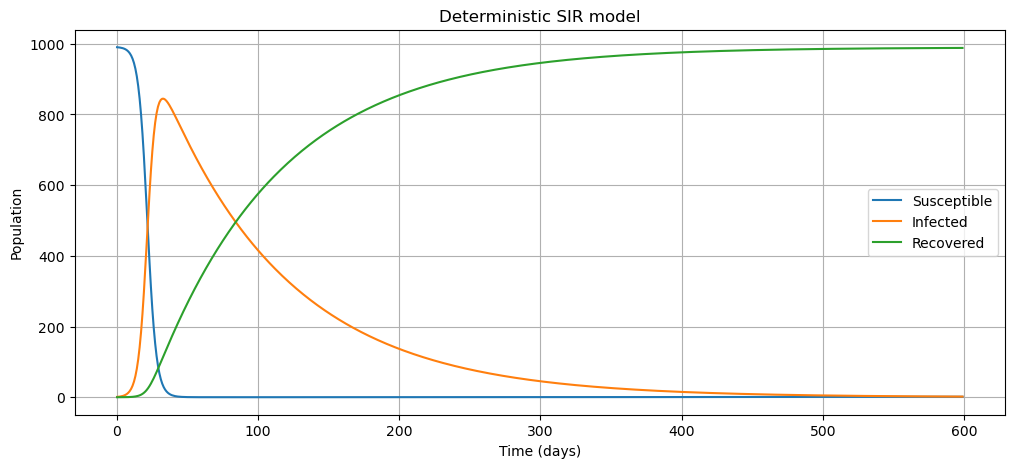

In [50]:
from scipy.integrate import odeint
from scipy.optimize import curve_fit
import numpy as np
import matplotlib.pyplot as plt

beta = 1
gamma = 1/30
mu = 1/60
N = 1000
X0 = 990
Y0 = 1
Z0 = 0
start_t = 0
end_t = 200
points_t = 600
init_val = [X0, Y0, Z0]

def SIR(X, t, beta, gamma, mu):
    """ 
    This function defines the ordinary differential equations for the compartments S, I and R. It then returns the differentials as an array.
    """
    X, Y, Z = X

    dXdt = mu - beta * X * Y / N - mu * X / N
    dYdt = beta * X * Y / N - gamma * Y - mu * Y / N
    dZdt = gamma * Y - mu * Z / N
    
    return np.array([dXdt, dYdt, dZdt])


def deterSol(X0, Y0, Z0, N, beta, gamma, mu, start_t, end_t, points_t):

    time = np.linspace(start_t, end_t, points_t)
    solution = odeint(SIR, init_val, time, args=(beta, gamma, mu))
    Xd, Yd, Zd = solution.T

    return Xd, Yd, Zd, time


Xd, Yd, Zd, time = deterSol(X0, Y0, Z0, N, beta, gamma, mu, start_t, end_t, points_t)

plt.figure(figsize=(12,5))
plt.plot(Xd, label="Susceptible")
plt.plot(Yd, label="Infected")
plt.plot(Zd, label = "Recovered")
plt.xlabel("Time (days)")
plt.ylabel("Population")
plt.title("Deterministic SIR model")
plt.legend()
plt.grid()

# plt.savefig('FittingSIR.png', dpi=300)
plt.show()


#### This is the Stochastic thing

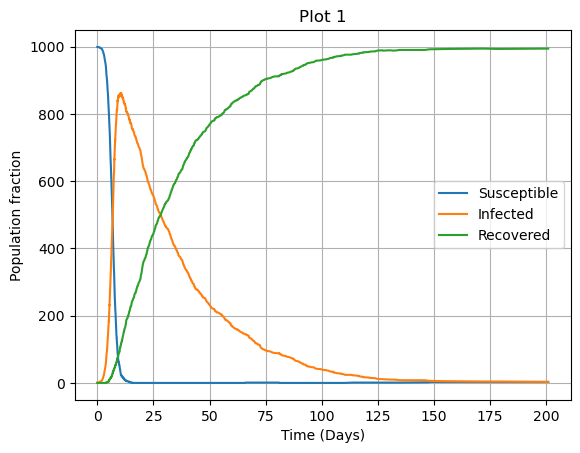

In [58]:
import matplotlib.pyplot as plt
import gillespie as gp
import numpy as np

beta = 1
gamma = 1/30
mu = 1/60
N = 1000
X0 = 999
Y0 = 1
Z0 = 0
init_val = [X0, Y0, Z0]

def gillespie_SIR(X, Y, Z, N, beta, gamma, mu):
    propensities = [lambda X, Y, Z: mu,
                lambda X, Y, Z: beta * X * Y / N,
                lambda X, Y, Z: gamma * Y,
                lambda X, Y, Z: mu * X / N,
                lambda X, Y, Z: mu * Y / N,
                lambda X, Y, Z: mu * Z / N]

    stoichiometry = [[1, 0, 0],
                 [-1, 1, 0],
                 [0, -1, 1],
                 [-1, 0, 0],
                 [0, -1, 0],
                 [0, 0, -1]]

    times, XYZ = gp.simulate(init_val, propensities, stoichiometry, duration = 200) 

    Xs, Ys, Zs = zip(*XYZ)

    return Xs, Ys, Zs, times

Xs, Ys, Zs, times = gillespie_SIR(X0, Y0, Z0, N, beta, gamma, mu)


plt.plot(times, Xs, label = "Susceptible")
plt.plot(times, Ys, label = "Infected")
plt.plot(times, Zs, label = "Recovered")

plt.title("Plot 1")
plt.xlabel("Time (Days)")
plt.ylabel("Population fraction")
plt.legend()
plt.grid()

plt.show()

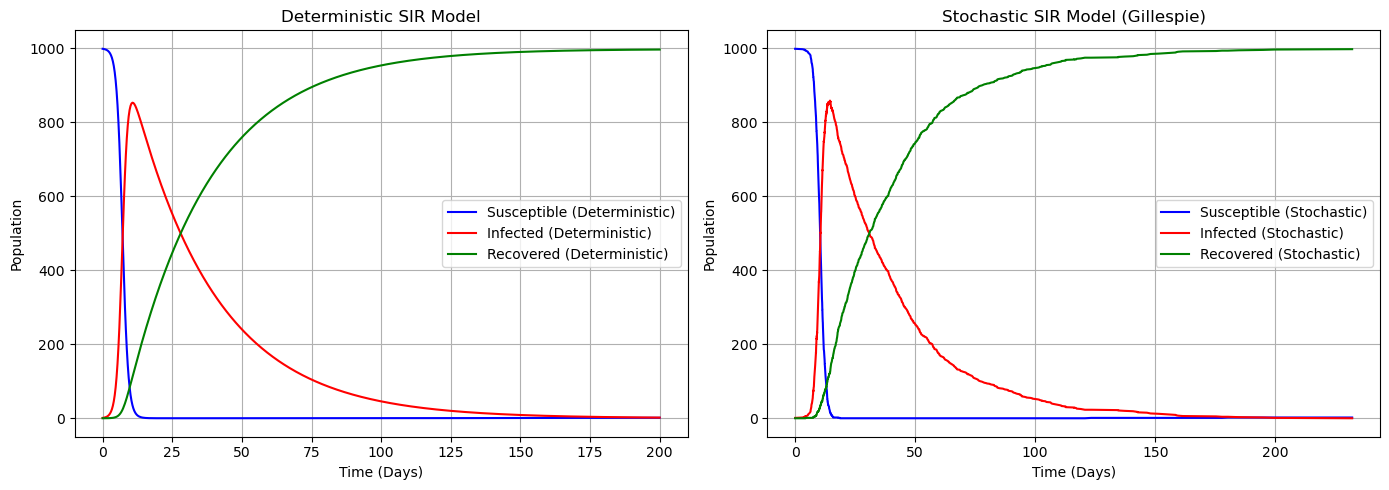

In [55]:
# Plot both the deterministic and stochastic models on the same figure

# First, solve the deterministic model
Xd, Yd, Zd, time = deterSol(X0, Y0, Z0, N, beta, gamma, mu, start_t, end_t, points_t)

# Now, solve the stochastic model using the Gillespie algorithm
Xs, Ys, Zs, times = gillespie_SIR(X0, Y0, Z0, N, beta, gamma, mu)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

# Plot the deterministic model on the first subplot (ax1)
ax1.plot(time, Xd, label="Susceptible (Deterministic)", color='blue')
ax1.plot(time, Yd, label="Infected (Deterministic)", color='red')
ax1.plot(time, Zd, label="Recovered (Deterministic)", color='green')
ax1.set_title("Deterministic SIR Model")
ax1.set_xlabel("Time (Days)")
ax1.set_ylabel("Population")
ax1.legend(loc="best")
ax1.grid(True)

# Plot the stochastic model on the second subplot (ax2)
ax2.plot(times, Xs, label="Susceptible (Stochastic)", color='blue')
ax2.plot(times, Ys, label="Infected (Stochastic)", color='red')
ax2.plot(times, Zs, label="Recovered (Stochastic)", color='green')
ax2.set_title("Stochastic SIR Model (Gillespie)")
ax2.set_xlabel("Time (Days)")
ax2.set_ylabel("Population")
ax2.legend(loc="best")
ax2.grid(True)

# Adjust layout and show the plot
plt.tight_layout()
plt.show()


In [59]:
simulations = 50

susceptible_sol = np.array([]).mean()
infected_sol = np.array([]).mean()

for i in range(simulations):
    Xs, Ys, Zs, times = gillespie_SIR(X0, Y0, Z0, N, beta, gamma, mu)
    np.append(susceptible_sol, Xs)
    np.append(infected_sol, Ys)

susceptible_var = np.var(susceptible_sol)
infected_var = np.var(infected_sol)

print(susceptible_var, susceptible_var)

nan nan


/var/folders/sq/c9xq2zk97n3cf_nqf5x49c0w0000gn/T/ipykernel_36587/3637023303.py:3: RuntimeWarning: Mean of empty slice.
  susceptible_sol = np.array([]).mean()
/var/folders/sq/c9xq2zk97n3cf_nqf5x49c0w0000gn/T/ipykernel_36587/3637023303.py:4: RuntimeWarning: Mean of empty slice.
  infected_sol = np.array([]).mean()
